# 任务描述：编写一个钱币定位系统，其不仅能够检测出输入图像中各个钱币的边缘，同时，还能给出各个钱币的圆心坐标与半径

### 一、核心模块:实现了边缘提取和圆形检测

#### 1.自定义Canny类

In [1]:
import numpy as np
class Canny:
    """实现了Canny边缘检测算法

    Attributes:
        image: np.ndarray 灰度图
        gray_image: np.ndarray 最初的灰度图
        y: int 图像的高
        x: int 图像的宽
        Guassian_kernel_size: int 高斯核尺寸
        sigma: float 标准差大小
        sign: bool 选择算子
        sobel: bool 选择算子
        prewitt_x:  np.ndarray 水平梯度算子
        prewitt_y:  np.ndarray 垂直梯度算子
        sobel_x:  np.ndarray 水平梯度算子
        sobel_y:  np.ndarray 垂直梯度算子
        high_threshold: int 滞后阈值法中的高阈值
        low_threshold: int 滞后阈值法中的低阈值
        guassian_image: np.ndarray 高斯滤波结果
        gradient_angle: np.ndarray 梯度方向矩阵
        tan: np.ndarray 梯度方向的tan值矩阵
        gradient_x: np.ndarray 水平方向梯度图
        gradient_y: np.ndarray 垂直方向梯度图
        gradient_image: np.ndarray 梯度图
        non_max_sup_image: np.ndarray 非极大化抑制结果
        edge_image: np.ndarray 滞后双阈值法得到的最终边缘图           
    """
    def __init__(self, image: np.ndarray, Guassian_kernel_size: int = 7, sigma: float = 1.0, 
                 high_threshold: int = 12, low_threshold: int = 4 ,sign :bool = False, sobel: bool = False):
        '''图片规范化，初始化检测参数

        Args:
            image: 输入的图片，之后作为每一步的结果
            sign: 判断选择基础的梯度算子还是sobel或者是prewitt
            sobel: 判断选择sobel还是prewitt
            ...omit
        
        Raises:
            ValueError: 输入图片不是灰度图时引发错误
        '''
        #如果数据类型是float，说明像素值范围是0-1
        if 'float' in str(image.dtype) :
            self.image=(image*255).astype(np.uint8)
        else :
            self.image=image
        if len(image.shape) == 3:
            raise ValueError('请输入灰度图')  
        self.gray_image=self.image
        self.y,self.x=self.image.shape
        self.Guassian_kernel_size = Guassian_kernel_size
        self.sigma=sigma
        self.high_threshold = high_threshold
        self.low_threshold = low_threshold
        self.sign=sign
        self.sobel=sobel
        self.prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        self.prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
        self.sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        self.sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        #调用算法
        self.canny_algorithm()

    def Gaussian_kernel(self) -> np.ndarray:
        """创建高斯核
    
        Returns:   
            指定大小的高斯核
        """
        print('创建高斯核')
        p=self.Guassian_kernel_size//2
        kernel=np.zeros((self.Guassian_kernel_size,self.Guassian_kernel_size))
        for x in range(-p,p+1) :
            for y in range(-p,p+1) :
                kernel[x+p,y+p]=(1/2*np.pi*self.sigma**2)*np.exp(-(x**2+y**2)/(2*self.sigma**2))
        kernel/=kernel.sum()
        return kernel
    
    def Gaussian_Blur(self) -> np.ndarray:
        """进行高斯滤波
        
        Returns:
            高斯滤波后的图片
        """
        print ('进行高斯滤波')
        gaussian_kernel=self.Gaussian_kernel()
        height, width = self.image.shape
        gaussian_kernel_size=gaussian_kernel.shape[0]
        pad=gaussian_kernel_size//2
        padded_image = np.pad(self.image, pad, mode='constant')
        self.image = np.zeros_like(self.image)
        for row in range(height):
            for col in range(width):            
                self.image[row, col] = np.sum(np.multiply(gaussian_kernel ,padded_image[row:row + gaussian_kernel_size, col:col + gaussian_kernel_size]))
        self.gaussian_image = np.clip(self.image, 0, 255)
        self.image=self.gaussian_image
        return self.gaussian_image
    
    def Get_gradient_img(self) -> np.ndarray:
        ''' 选择一阶差分算子,计算梯度图和梯度方向矩阵
        
        Returns: 
            生成的梯度图
        '''
        print ('生成梯度图')
        padded_image = np.pad(self.image, 1, mode='constant')
        #因为self.image是np.uint8，为了保存梯度的方向需要保存负号
        self.gradient_x=np.zeros_like(self.image,dtype=np.float64)
        self.gradient_y=np.zeros_like(self.image,dtype=np.float64)  
        if self.sign :
            print("选择梯度算子")
            if  self.sobel :
                print("sobel算子")
                conv_x=self.sobel_x
                conv_y=self.sobel_y
            else :
                print("prewitt算子")
                conv_x=self.prewitt_x
                conv_y=self.prewitt_y
            for i in range(self.y):
                for j in range(self.x):
                # 提取当前像素区域
                    # 计算卷积结果
                    self.gradient_x[i, j] = np.sum(padded_image[i:i+3, j:j+3] * conv_x)
                    self.gradient_y[i, j] = np.sum(padded_image[i:i+3, j:j+3] * conv_y)

        else :
            print("选择最简单的算子")
            x_kernel = np.array([[-1, 1]])
            y_kernel = np.array([[-1], [1]])
            for i in range(self.x) :
                for j in range(self.y) :
                    if i==self.x-1 : 
                        self.gradient_x[j][i]=0
                    else : 
                        self.gradient_x[j][i]=np.dot(x_kernel,np.array([[self.image[j][i]],[self.image[j][i+1]]]))[0][0]
                    if j==self.y-1 : 
                        self.gradient_y[j][i]=0
                    else : 
                        self.gradient_y[j][i]=np.dot(np.array([[self.image[j][i],self.image[j+1][i]]]),y_kernel)[0][0]
        self.gradient_image= np.clip(np.sqrt(self.gradient_x**2 + self.gradient_y**2),0,255).astype(np.uint8)
        self.image=self.gradient_image
        self.gradient_angle=np.arctan2(self.gradient_y,self.gradient_x)
        self.tan=np.tan(self.gradient_angle)
        return self.gradient_image
    
    def Non_maximum_suppression (self) -> np.ndarray:
        '''根据tan值的大小和正负,对生成的梯度图进行非极大化抑制
        
        Returns:
            生成的非极大化抑制结果图
        '''
        print ('非极大化抑制')
        result=np.zeros_like(self.image)
        y,x=result.shape
        for i in range(1,x-1) :
            for j in range(1,y-1) :
                #注意正方向指向右下角
                if np.abs(self.tan[j][i]) >1:
                    gradient_2=self.image[j-1][i]
                    gradient_4=self.image[j+1][i]
                    #g1 g2
                    #   C
                    #   g4 g3 
                    if self.tan[j][i] >0:
                        gradient_1=self.image[j-1][i-1]
                        gradient_3=self.image[j+1][i+1]
                    #   g2 g1
                    #   C
                    #g3 g4  
                    else :
                        gradient_1=self.image[j-1][i+1]
                        gradient_3=self.image[j+1][i-1]
                    Temp1 = np.abs(1/self.tan[j][i]) * gradient_1 + (1 - 1/np.abs(self.tan[j][i])) * gradient_2
                    Temp2 = np.abs(1/self.tan[j][i]) * gradient_3 + (1 - 1/np.abs(self.tan[j][i])) * gradient_4
                else :
                    gradient_2=self.image[j][i-1]
                    gradient_4=self.image[j][i+1]
                    #g1
                    #g2 C g4
                    #     g3
                    if self.tan[j][i] >0:
                        gradient_1=self.image[j-1][i-1]
                        gradient_3=self.image[j+1][i+1]
                    #     g3
                    #g2 C g4
                    #g1
                    else :
                        gradient_1=self.image[j+1][i-1]
                        gradient_3=self.image[j-1][i+1]
                # 线性插值
                    Temp1 = np.abs(self.tan[j][i]) * gradient_1 + (1 - np.abs(self.tan[j][i])) * gradient_2
                    Temp2 = np.abs(self.tan[j][i]) * gradient_3 + (1 - np.abs(self.tan[j][i])) * gradient_4
                if  self.image[j][i] >= Temp1 and  self.image[j][i] >= Temp2:
                    result[j][i] =  self.image[j][i]
        self.image=result      
        self.non_max_sup_image=result 
        return self.non_max_sup_image

    def Hysteresis_thresholding(self) -> np.ndarray:
        '''对生成的非极大化抑制结果图进行滞后阈值法,图像中的像素点梯度值超过高阈值的称为强边缘,梯度小于低阈值的不是边缘,
        二者之间的称为弱边缘。当弱边缘的周围8邻域有强边缘点存在时,就将该弱边缘点变成强边缘点,以此来实现对强边缘的补充。

        Returns: 滞后阈值法结果图
        '''
        print ('滞后阈值法')
        final_image=self.image.copy()
        final_image[final_image>=self.high_threshold]=255
        final_image[final_image<=self.low_threshold]=0
        #注意这里：j是行，i是列。因为x是宽，y是高。
        for i in range(1,self.x-1):
            for j in range(1,self.y-1):
                if final_image[j][i]<self.high_threshold and  final_image[j][i]>self.low_threshold :
                    list_=[final_image[j-1][i-1],final_image[j-1][i],final_image[j-1][i+1],final_image[j][i-1],
                        final_image[j][i+1],final_image[j+1][i-1],final_image[j+1][i],final_image[j+1][i+1]]
                    for value in list_ :
                        if value >=self.high_threshold :
                            final_image[j][i]=255
                            break
                        else :
                            final_image[j][i]=0 
        self.image=final_image
        self.edge_image=final_image
        return self.edge_image
    
    def canny_algorithm(self) -> np.ndarray:
        '''按照顺序和步骤调用以上所有成员函数。

        Returns: Canny算法的结果,即最终的边缘图
        '''  
        self.Gaussian_Blur()
        self.Get_gradient_img()
        self.Non_maximum_suppression()
        self.Hysteresis_thresholding()



#### 2.自定义Hough类

In [2]:
import numpy as np
import math
class Hough_Circle:
    """实现了Houngh圆形检测算法

    Attributes:
        image: np.ndarray 边缘图
        angle: np.ndarray 输入的梯度方向矩阵
        step: int 变换步长大小
        threshold: int 筛选单元的阈值
        y: int 图像的高
        x: int 图像的宽
        radius: int 最大半径
        vote_matrix: np.nddaray 投票矩阵
        circles: list 结果列表
    """

    def __init__(self, image: np.ndarray, angle: np.ndarray, step: int = 4, threshold: int = 50):  
        '''初始化参数空间,将图像分割成一个个的格子，每个格子对应参数空间中的一个点。
        
        Args:
            image: Canny算法得到的结果
            ...omit
        '''
        self.image = image
        self.angle = np.abs(angle)
        self.y, self.x = self.image.shape #y代表行，x代表列
        self.radius = math.ceil(math.sqrt(self.y**2 + self.x**2)) #最大半径 
        self.step = step 
        self.vote_matrix = np.zeros([math.ceil(self.y / self.step), math.ceil(self.x / self.step), math.ceil(self.radius / self.step)])
        self.threshold = threshold
        self.circles = []
        self.hough_algorithm()

    def Hough_Vote(self) -> np.ndarray:
        '''沿梯度方向对空间中的所有单元进行投票,注意有两个方向
        
        Returns: 
            投票矩阵
        '''
        print ('霍夫变换')
        for i in range(1,self.y-1) :
            for j in range(1,self.x-1) :
                if self.image[i][j]>0:
                    #沿梯度的正方向
                    x_=j
                    y_=i
                    r=0
                    while x_<self.x and y_<self.y   : 
                        self.vote_matrix[math.floor(y_ / self.step),math.floor(x_ / self.step), math.floor(r/self.step)]+=1                
                        y_ += np.abs(self.step * math.sin(self.angle[i][j]))
                        x_ += np.abs(self.step * math.cos(self.angle[i][j]))
                        r += self.step
                    # 清零反向投票 
                    x_=j
                    y_=i
                    r=0
                    #沿梯度负方向
                    while x_>0 and y_>0 :
                        self.vote_matrix[math.floor(y_ / self.step),math.floor(x_ / self.step), math.floor(r/self.step)] +=1                
                        y_ -= np.abs(self.step * math.sin(self.angle[i][j]))
                        x_ -= np.abs(self.step * math.cos(self.angle[i][j]))
                        r += self.step
        print('投票完成')
        return self.vote_matrix
    
    def Select_Circle(self) -> list:
        '''按照阈值从投票矩阵中筛选出合适的圆

        Returns:
            候选圆列表
        '''
        print ('选择圆')
        #选出大于阈值的
        candidate=[]
        for i in range(0,math.ceil(self.y/self.step)) :
            for j in range(0,math.ceil(self.x/self.step)):
                for r in range(0,math.ceil(self.radius/self.step)):
                    if self.vote_matrix[i][j][r]>=self.threshold :                
                    #步长表示格子的边长,当需要将格子映射回图像空间时,取格子的中心点作为映射点。
                        a=math.ceil(j*self.step+1/2*self.step)
                        b=math.ceil(i*self.step+1/2*self.step)
                        r=math.ceil(r*self.step+1/2*self.step)
                        candidate.append([a,b,r])
        self.candidate=candidate
        return self.candidate

    def Non_maximum_suppression(self) -> list:
        """对可能重叠的圆做非极大化抑制,圆心坐标和半径取平均值

        Returns:
            结果圆列表
        """
        over=[]#已经判断完毕的
        result=[]
        for circle in self.candidate :
            compare=self.candidate#一样的列表用于循环比较
            avg=[0,0,0]
            count=0
            for near in compare :
                if near in over :
                    continue
                dis =math.sqrt((circle[0]-near[0])**2+(circle[1]-near[1])**2)
                if dis <circle[2]+near[2] :
                    avg[0]+=near[0]
                    avg[1]+=near[1]
                    avg[2]+=near[2]
                    count+=1
                    over.append(near)
            if count==0 :
                continue
            result.append([t/count for t in avg ])
        self.circles=result
        return self.circles
    
    def hough_algorithm(self) -> list:
        '''按照算法顺序调用以上成员函数

        Returns:
            圆形拟合结果,即圆的坐标及半径集合
        '''
        self.Hough_Vote()
        self.Select_Circle()
        self.Non_maximum_suppression()


### 二、功能模块：实现了一些功能函数

#### 函数封装

In [3]:
import matplotlib.pyplot as plt
import cv2
import os
def show(num,image_list,name_list=['1','2','3','4','5']):
    """在jupyter上一次性展示多张图片
    """
    if num>=5 :
        raise ValueError("num不能大于5")
    if num==1:
        plt.imshow(image_list,cmap='gray')
        plt.title(name_list[0])
        plt.axis('off')
    else :
        plt.figure(figsize=(14, 7))
        for i in range(num) :
            plt.subplot(1,num,i+1)
            plt.imshow(image_list[i],cmap='gray')
            plt.title(name_list[i])
            plt.axis('off')

def preprocess(image,scale):
    """图像预处理,先resize,再gray
    """
    if len(image.shape) == 3:
        height,weight=image.shape[0:2]
    else :
        height,weight=image.shape
    image=cv2.resize(image,(weight//scale,height//scale))
    gray_image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    return image,gray_image

def count_pixel(img,Path):
    """统计像素值大小分布情况,为Canny边缘检测的阈值提供参考
    """
    arr=img
    # 创建一个空字典用于存储统计结果
    count_dict = {}
    # 遍历数组，统计每个数字的个数
    for row in arr:
        for num in row:
            if num in count_dict:
                count_dict[num] += 1
            else:
                count_dict[num] = 1
    # 对统计结果按照值（出现次数）进行排序
    sorted_count = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    # 将排序后的统计结果写入到 txt 文件中
    with open(Path, 'w') as file:
        # 逐行写入排序后的键值对
        for key, value in sorted_count:
            file.write(f"数字 {key} 出现了 {value} 次\n")
    print("文本生成")

def sort_martix(vote_matrix,n):
    """投票矩阵票数从大到小排列,为选择阈值提供参考
    """
    vote_matrix=vote_matrix.flatten() 
    sorted_indices = np.argsort(vote_matrix)[::-1]  # 从大到小排序后的索引
    # 获取前n个最大值
    top_n_max_values = vote_matrix[sorted_indices[:n]]
    print(f"最大的前{n}个数:", top_n_max_values)

def save_image(Dir,coin_detector):
    """依次保存所有的过程结果
    """
    if not os.path.exists(Dir):
        os.makedirs(Dir)
    cv2.imwrite(f'{Dir}/gray_image.jpg',coin_detector.canny_detector.gray_image)
    cv2.imwrite(f'{Dir}/gaussian_image.jpg',coin_detector.canny_detector.gaussian_image)
    cv2.imwrite(f'{Dir}/gradient_image.jpg',coin_detector.canny_detector.gradient_image)
    cv2.imwrite(f'{Dir}/non_max_sup_image.jpg',coin_detector.canny_detector.non_max_sup_image)
    cv2.imwrite(f'{Dir}/edge_image.jpg',coin_detector.canny_detector.edge_image)
    #RGB转BGR,plt是RGB,cv2保存的是BGR
    bgr_image=cv2.cvtColor(coin_detector.origin_image,cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'{Dir}/result.jpg', bgr_image)
    print('保存成功')


### 三、模块整合：创建钱币定位系统类

In [4]:
class CoinDetectionSystem:
    """实现了一个钱币定位系统
    
    输入的参数有两张图片,一个是用于显示拟合结果的resize后的原图,第二个是灰度图
    
    Attributes:
        canny_detector: class Canny边缘检测器
        hough_circle_detector: class Hough圆检测器 
        circles: list 圆形拟合结果,即圆的坐标及半径集合
        origin_image: np.ndarray resize后的原图
    """
    def __init__(self, origin_image: np.ndarray, image: np.ndarray, Gaussian_kernel_size: int = 7, sigma: float = 1.0, high_threshold: int = 12,
                low_threshold: int = 4, step: int = 4, threshold: int = 50, sign :bool = False, sobel: bool = False):
        """初始化算法参数,创建两个检测器，并直接输出结果
        
        Args:
            image: 灰度图
            ...omit
        """
        self.origin_image=origin_image
        self.canny_detector = Canny(image,Gaussian_kernel_size,sigma,high_threshold,low_threshold,sign,sobel)  
        edges = self.canny_detector.edge_image
        self.hough_circle_detector = Hough_Circle(edges,self.canny_detector.gradient_angle,step,threshold)  
        self.circles = self.hough_circle_detector.circles
        self.plot_coins_fitting()
    def plot_coins_fitting(self):
        """ 原图与预测的圆形拟合
        """
        self.circles.sort(key=lambda x: x[0])  # 按照半径排序
        for (a, b, r) in self.circles:
            print(f'圆心坐标: ({a}, {b}), 半径: {r}')
            cv2.circle(self.origin_image, (int(a), int(b)), 4, (255, 0, 0), -1) 
            cv2.circle(self.origin_image, (math.ceil(a), math.ceil(b)), math.ceil(r), (0, 255, 0), 3)
        plt.title('Detected Coins')
        plt.axis('off')
        plt.imshow(self.origin_image)  



### 四、钱币定位实例

#### 实例1

进行高斯滤波
创建高斯核
生成梯度图
选择梯度算子
prewitt算子
非极大化抑制
滞后阈值法
霍夫变换
投票完成
选择圆
圆心坐标: (214.0, 204.4), 半径: 42.0
圆心坐标: (310.0, 598.0), 半径: 42.0
圆心坐标: (514.0, 401.3333333333333), 半径: 50.0
圆心坐标: (714.0, 642.0), 半径: 42.0
圆心坐标: (826.0, 214.0), 半径: 42.0
圆心坐标: (966.0, 447.3333333333333), 半径: 44.666666666666664


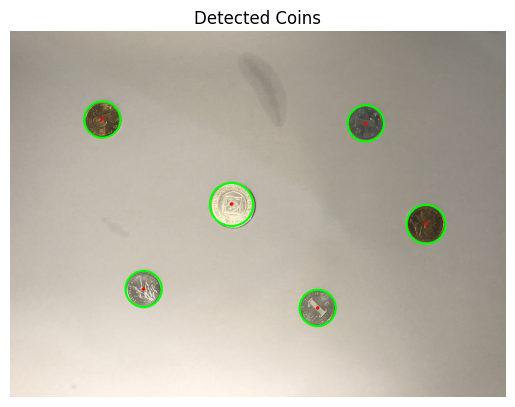

In [5]:
origin_image = plt.imread('coin1.jpg')  
#缩小3倍
origin_image,gray_image=preprocess(origin_image,3)
# 创建钱币定位系统对象
coin_detector1 = CoinDetectionSystem(origin_image,gray_image,3,1,30,15,4,60,True)


#### 实例2

进行高斯滤波
创建高斯核
生成梯度图
选择梯度算子
prewitt算子
非极大化抑制
滞后阈值法
霍夫变换
投票完成
选择圆
圆心坐标: (154.0, 342.0), 半径: 82.0
圆心坐标: (286.0, 532.0), 半径: 72.0
圆心坐标: (288.0, 204.0), 半径: 81.0
圆心坐标: (398.0, 363.3333333333333), 半径: 70.0
圆心坐标: (586.0, 368.0), 半径: 66.0
圆心坐标: (594.0, 582.0), 半径: 70.0
圆心坐标: (779.6, 162.0), 半径: 86.8
圆心坐标: (806.0, 454.0), 半径: 90.0
圆心坐标: (956.0, 282.0), 半径: 68.0
圆心坐标: (1078.0, 454.0), 半径: 70.0


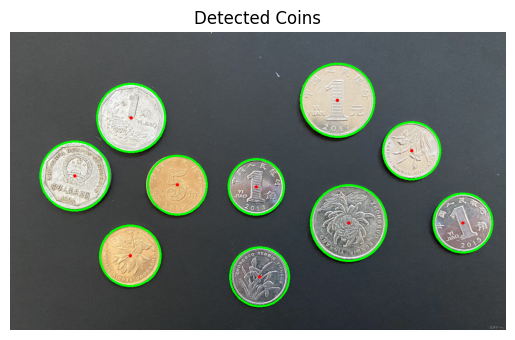

In [6]:
origin_image = plt.imread('coin2.jpg')  
#缩小3倍
origin_image,gray_image=preprocess(origin_image,3)
# 创建钱币定位系统对象
coin_detector2 = CoinDetectionSystem(origin_image,gray_image,3,1,45,25,4,90,True)

#### 功能函数的使用

统计投票矩阵票数

In [7]:
# count_pixel(coin_detector1.canny_detector.non_max_sup_image,'./count1.txt')
sort_martix(coin_detector1.hough_circle_detector.vote_matrix,20)
# count_pixel(coin_detector2.canny_detector.non_max_sup_image,'./count2.txt')
sort_martix(coin_detector2.hough_circle_detector.vote_matrix,20)

文本生成
最大的前20个数: [105.  84.  79.  76.  76.  73.  72.  71.  68.  67.  66.  66.  66.  64.
  64.  63.  61.  59.  59.  59.]
文本生成
最大的前20个数: [159. 158. 130. 124. 117. 115. 113. 113. 108. 108. 106. 106. 101. 101.
 100. 100.  98.  98.  98.  93.]


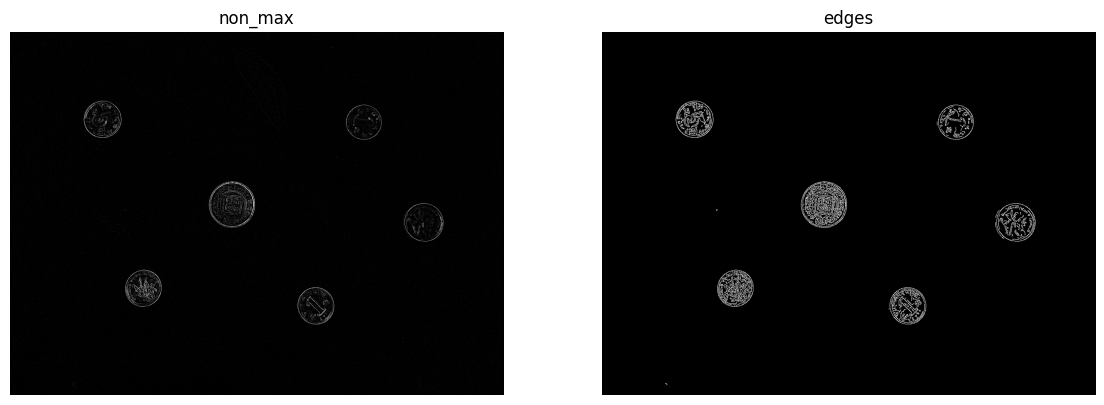

In [8]:
show(2,[coin_detector1.canny_detector.non_max_sup_image,coin_detector1.canny_detector.edge_image],['non_max','edges'])

如果需要保存结果，请自己修改保存路径以及钱币定位器对象的名称

In [9]:
# save_image('./results_k=3_sigma=1/coin1/prewitt',coin_detector1)
# save_image('./results_k=3_sigma=1/coin2/prewitt',coin_detector2)

保存成功
保存成功
